# <center>ДЗ 3, Сравнение методов классификации</center>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
warnings.filterwarnings('ignore')  # отключаем предупреждения

## Чтение данных

In [2]:
df = pd.read_csv('dataset/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


Возьмём данные заболеваний сердца у пациентов, которые можно скачать [тут](https://www.kaggle.com/code/ahmedadell30/heart-disease-prediction-with-ann-models/data).

Описание датасета: <br>

* age - age in years <br>
* sex - (1 = male; 0 = female) <br>
* cp - chest pain type <br>
* trestbps - resting blood pressure (in mm Hg on admission to the hospital) <br>
* chol - serum cholestoral in mg/dl <br>
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) <br>
* restecg - resting electrocardiographic results <br>
* thalach - maximum heart rate achieved <br>
* exang - exercise induced angina (1 = yes; 0 = no) <br>
* oldpeak - ST depression induced by exercise relative to rest <br>
* slope - the slope of the peak exercise ST segment <br>
* ca - number of major vessels (0-3) colored by flourosopy <br>
* thal - 3 = normal; 6 = fixed defect; 7 = reversable defect <br>
* target - have disease or not (1=yes, 0=no)

Необходимо решить задачу классификации и научиться предсказывать целовой признак **target** имеет ли пациент заболевание сердца.

In [3]:
print(df.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [4]:
print(df.duplicated().sum())

723


Пустых строк нет, но есть дубликаты, надо поправить

In [5]:
df = df.drop_duplicates()

print(df.duplicated().sum())


0


## Разведочный анализ данных

**Посмотрим распределение признаков**

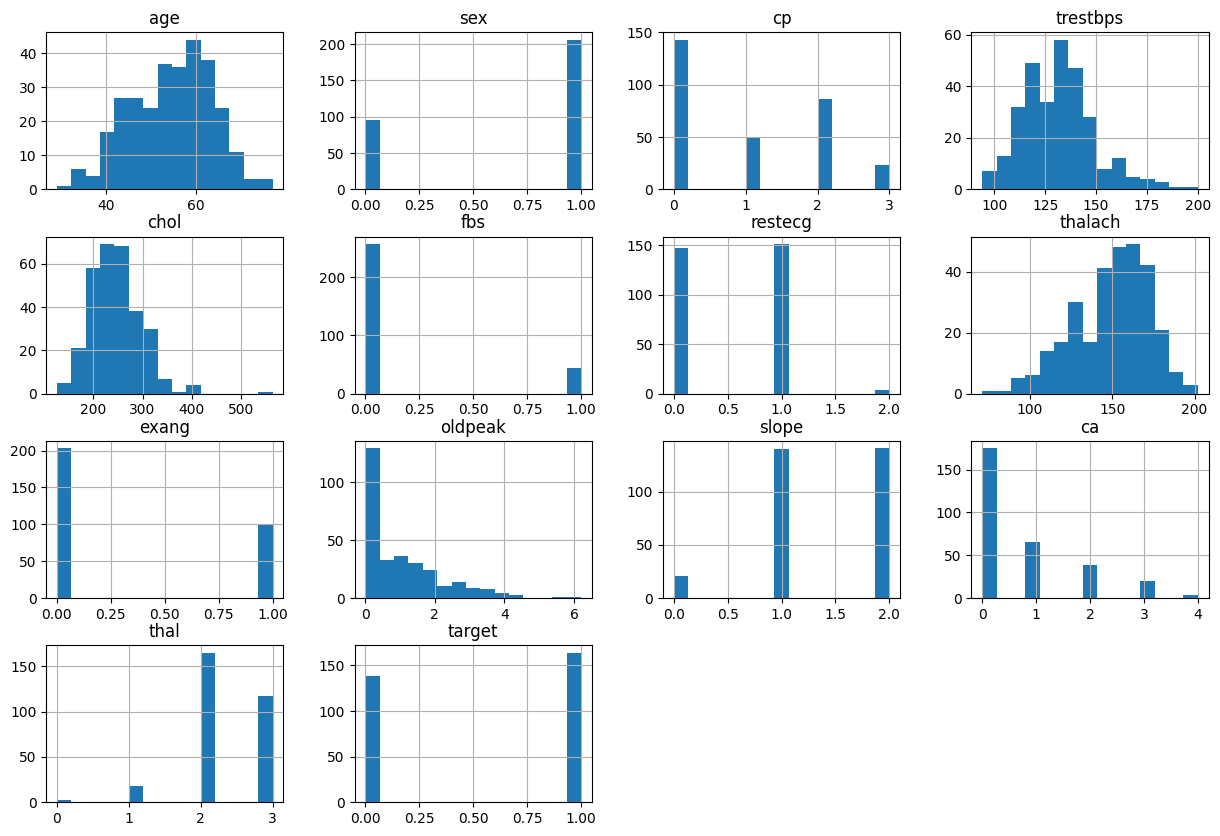

In [6]:
df.hist(bins=15, figsize=(15, 10))
plt.show()

**Посмотрим корреляцию признаков**

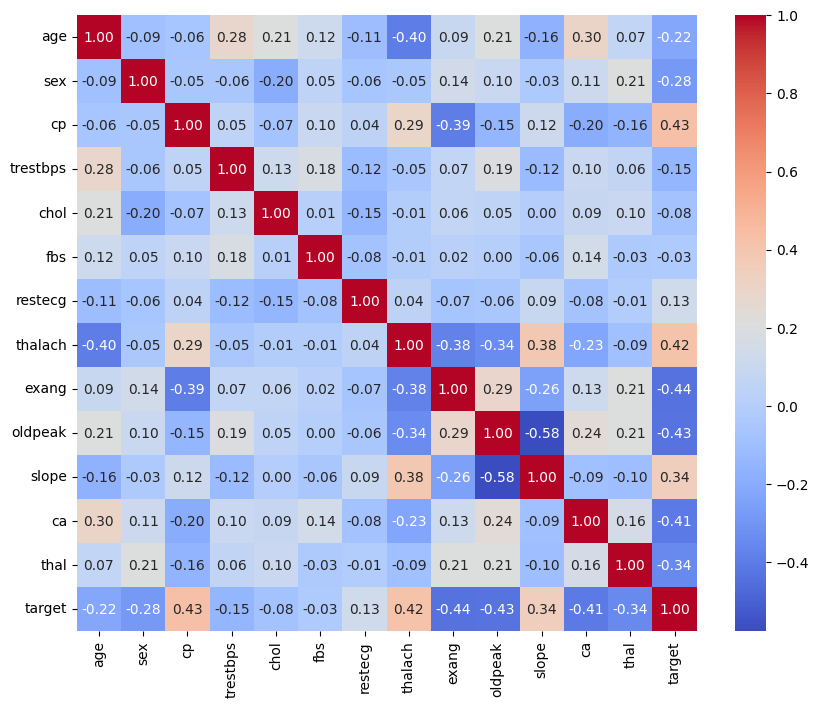

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()


Имеем высокую корреляцию между признаками: oldpeak и slope. Оставляем oldpeak так как он лучше коррелирует с target

Так же предлагаю удалить признаки restecg, fbs, chol, trestbps так как они имеют малую корреляцию с предсказываемым признаком target

In [8]:
df = df.drop(columns=['slope','restecg', 'fbs', 'chol', 'trestbps'])

### Преобразование категориальных признаков

Закодируем категориальные признаки **cp**, **thal**.

In [9]:
cp_dum = pd.get_dummies(df['cp'], prefix = "cp")
thal_dum = pd.get_dummies(df['thal'], prefix = "thal")

frames = [df, cp_dum, thal_dum]
df = pd.concat(frames, axis = 1)
df.head()

,age,sex,cp,thalach,exang,oldpeak,ca,thal,target,cp_0,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3
0,52,1,0,168,0,1.0,2,3,0,True,False,False,False,False,False,False,True
1,53,1,0,155,1,3.1,0,3,0,True,False,False,False,False,False,False,True
2,70,1,0,125,1,2.6,0,3,0,True,False,False,False,False,False,False,True
3,61,1,0,161,0,0.0,1,3,0,True,False,False,False,False,False,False,True
4,62,0,0,106,0,1.9,3,2,0,True,False,False,False,False,False,True,False


In [10]:
df = df.drop(columns = ['cp', 'thal'])
df.head()

,age,sex,thalach,exang,oldpeak,ca,target,cp_0,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3
0,52,1,168,0,1.0,2,0,True,False,False,False,False,False,False,True
1,53,1,155,1,3.1,0,0,True,False,False,False,False,False,False,True
2,70,1,125,1,2.6,0,0,True,False,False,False,False,False,False,True
3,61,1,161,0,0.0,1,0,True,False,False,False,False,False,False,True
4,62,0,106,0,1.9,3,0,True,False,False,False,False,False,True,False


## Реализация Логистической регрессии

In [18]:
class MyLogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.theta = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def cost_function(self, X, y):
        m = len(y)
        h = self.sigmoid(X.dot(self.theta))
        cost = -(1/m) * (y.T.dot(np.log(h)) + (1 - y).T.dot(np.log(1 - h)))
        return cost

    def gradient_descent(self, X, y):
        m = len(y)
        cost_history = []

        for _ in range(self.iterations):
            h = self.sigmoid(X.dot(self.theta))
            gradient = (1/m) * X.T.dot(h - y)
            self.theta -= self.learning_rate * gradient
            cost_history.append(self.cost_function(X, y))

        return cost_history

    def fit(self, X, y):
        X = np.c_[np.ones((X.shape[0], 1)), X]
        self.theta = np.zeros(X.shape[1])
        self.gradient_descent(X, y)

    def predict(self, X):
        X = np.c_[np.ones((X.shape[0], 1)), X]
        predictions = self.sigmoid(X.dot(self.theta))
        return [1 if i >= 0.5 else 0 for i in predictions]

    def predict_proba(self, X):
        X = np.c_[np.ones((X.shape[0], 1)), X]
        return self.sigmoid(X.dot(self.theta))

    def get_params(self, deep=True):
        return {'learning_rate': self.learning_rate, 'iterations': self.iterations}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self



## Масштабирование

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

y = df['target']
X = df.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)


X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

## Кросс-валидация и гиперпараметры

In [13]:
from sklearn.model_selection import cross_val_score

my_lr_model = MyLogisticRegression(learning_rate=0.01, iterations=1000)  

cv_scores = cross_val_score(my_lr_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV accuracy = %.4f" % np.mean(cv_scores))

Cross validation scores:
	 0.7442
	0.9048
	0.8333
	0.9286
	0.8571
Mean CV accuracy = 0.8536


**Качество модели хорошо бы сравнить. Например, с глупым предсказателем.**

In [14]:
from sklearn.metrics import accuracy_score

stupid_pred_train = np.full_like(y_train, y_train.mean() > 0.5)
stupid_pred_test = np.full_like(y_test, y_train.mean() > 0.5)

print("Train accuracy with stupid predictor:", accuracy_score(y_train, stupid_pred_train))
print("Test accuracy with stupid predictor:", accuracy_score(y_test, stupid_pred_test))


Train accuracy with stupid predictor: 0.5734597156398105
Test accuracy with stupid predictor: 0.4725274725274725


Видим, что наша модель сильно точнее чем предсказание наиболее частого класса

In [18]:
my_lr_model.fit(X_train_scaled, y_train)
y_test_pred = my_lr_model.predict(X_test_scaled)

my_lr_test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy with our model:", my_lr_test_accuracy)
accuracies = {}
accuracies['My Logistic Regression'] = my_lr_test_accuracy

Test accuracy with our model: 0.8021978021978022


## Logistic Regression

### Разделяющая гиперплоскость
<br>
<img src="https://www.tutorialspoint.com/machine_learning_with_python/images/red_line.jpg" width="500px"/>

### Сигмоидная функция для оценки вероятности принадлежности к классу 1
<br>
<img src="https://qph.fs.quoracdn.net/main-qimg-05edc1873d0103e36064862a45566dba" width="500px"/>

In [19]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=10000)

cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV accuracy = %.4f" % np.mean(cv_scores))

lr_model.fit(X_train_scaled, y_train)

y_test_pred = lr_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy with Logistic Regression:", test_accuracy)
accuracies['Logistic Regression'] = test_accuracy

Cross validation scores:
	 0.7442
	0.9048
	0.7857
	0.8810
	0.7857
Mean CV accuracy = 0.8203
Test accuracy with Logistic Regression: 0.8131868131868132


## K-Nearest Neighbour (KNN) Classification

**KNN Algorithm**
<br>
<img src="http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531424125/KNN_final_a1mrv9.png"/>

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)  # Можно настроить n_neighbors

cv_scores = cross_val_score(knn_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross validation scores (KNN):\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV accuracy (KNN) = %.4f" % np.mean(cv_scores))

knn_model.fit(X_train_scaled, y_train)

y_test_pred = knn_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy with KNN:", test_accuracy)
accuracies['KNN'] = test_accuracy

Cross validation scores (KNN):
	 0.7674
	0.8333
	0.7619
	0.9286
	0.7857
Mean CV accuracy (KNN) = 0.8154
Test accuracy with KNN: 0.7802197802197802


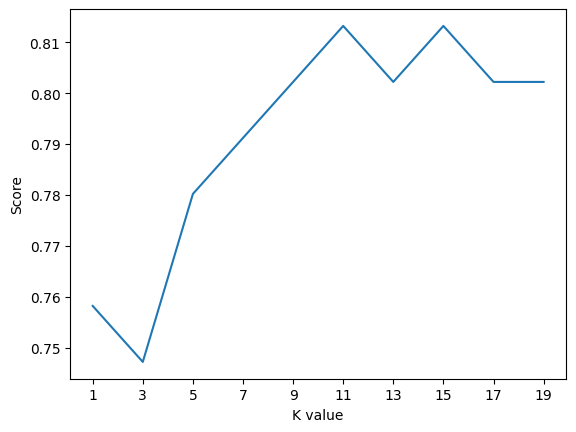

Maximum KNN Score is 0.8132


In [21]:
scoreList = []
for i in range(1, 20, 2):
    knn2 = KNeighborsClassifier(n_neighbors = i)
    knn2.fit(X_train_scaled, y_train)
    scoreList.append(knn2.score(X_test_scaled, y_test))
    
plt.plot(range(1, 20, 2), scoreList)
plt.xticks(np.arange(1, 20, 2))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)
accuracies['KNN'] = acc
print("Maximum KNN Score is {:.4f}".format(acc))

## Support Vector Machine (SVM)

**Support Vector Machine Algorithm**
<br>
<img src="https://cdn-images-1.medium.com/max/1600/1*TudH6YvvH7-h5ZyF2dJV2w.jpeg" width="500px"/><br>
<img src="https://aitrends.com/wp-content/uploads/2018/01/1-19SVM-2.jpg" width="500px"/>


In [22]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', C=1.0)  # Параметры можно настроить

cv_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross validation scores (SVM):\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV accuracy (SVM) = %.4f" % np.mean(cv_scores))

svm_model.fit(X_train_scaled, y_train)

y_test_pred = svm_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy with SVM:", test_accuracy)
accuracies['SVM'] = test_accuracy

Cross validation scores (SVM):
	 0.7907
	0.8810
	0.8095
	0.9048
	0.8333
Mean CV accuracy (SVM) = 0.8439
Test accuracy with SVM: 0.8131868131868132


## Naive Bayes Algorithm

In [23]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()

cv_scores = cross_val_score(nb_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross validation scores (Naive Bayes):\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV accuracy (Naive Bayes) = %.4f" % np.mean(cv_scores))

nb_model.fit(X_train_scaled, y_train)

y_test_pred = nb_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy with Naive Bayes:", test_accuracy)
accuracies['Naive Bayes'] = test_accuracy

Cross validation scores (Naive Bayes):
	 0.7674
	0.9048
	0.8333
	0.9048
	0.8333
Mean CV accuracy (Naive Bayes) = 0.8487
Test accuracy with Naive Bayes: 0.7912087912087912


## Decision Tree Algorithm

<br>
<img src="https://christophm.github.io/interpretable-ml-book/images/tree-artificial-1.jpeg" width="600px"/><br>

In [24]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)

cv_scores = cross_val_score(dt_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross validation scores (Decision Tree):\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV accuracy (Decision Tree) = %.4f" % np.mean(cv_scores))

dt_model.fit(X_train_scaled, y_train)

y_test_pred = dt_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy with Decision Tree:", test_accuracy)
accuracies['Decision Tree'] = test_accuracy

Cross validation scores (Decision Tree):
	 0.6512
	0.8333
	0.7857
	0.7143
	0.8095
Mean CV accuracy (Decision Tree) = 0.7588
Test accuracy with Decision Tree: 0.7362637362637363


## Реализация метода ближайших соседей

In [27]:
class MyKNN:
    def __init__(self, k=5):
        self.k = k  

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def _predict(self, x):
        distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]
        
        k_indices = np.argsort(distances)[:self.k]
        
        k_nearest_labels = [self.y_train.iloc[i] for i in k_indices]
        
        most_common = np.bincount(k_nearest_labels).argmax()
        return most_common

    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

    def get_params(self, deep=True):
        return {"k": self.k}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


In [27]:
myknn_model = MyKNN(k=5)

cv_scores = cross_val_score(myknn_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV accuracy = %.4f" % np.mean(cv_scores))

myknn_model.fit(X_train_scaled, y_train)

y_test_pred = myknn_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy with KNN:", test_accuracy)
accuracies['My KNN'] = test_accuracy

Cross validation scores:
	 0.7674
	0.8571
	0.7857
	0.9286
	0.7857
Mean CV accuracy = 0.8249
Test accuracy with KNN: 0.7802197802197802


## Comparing Models

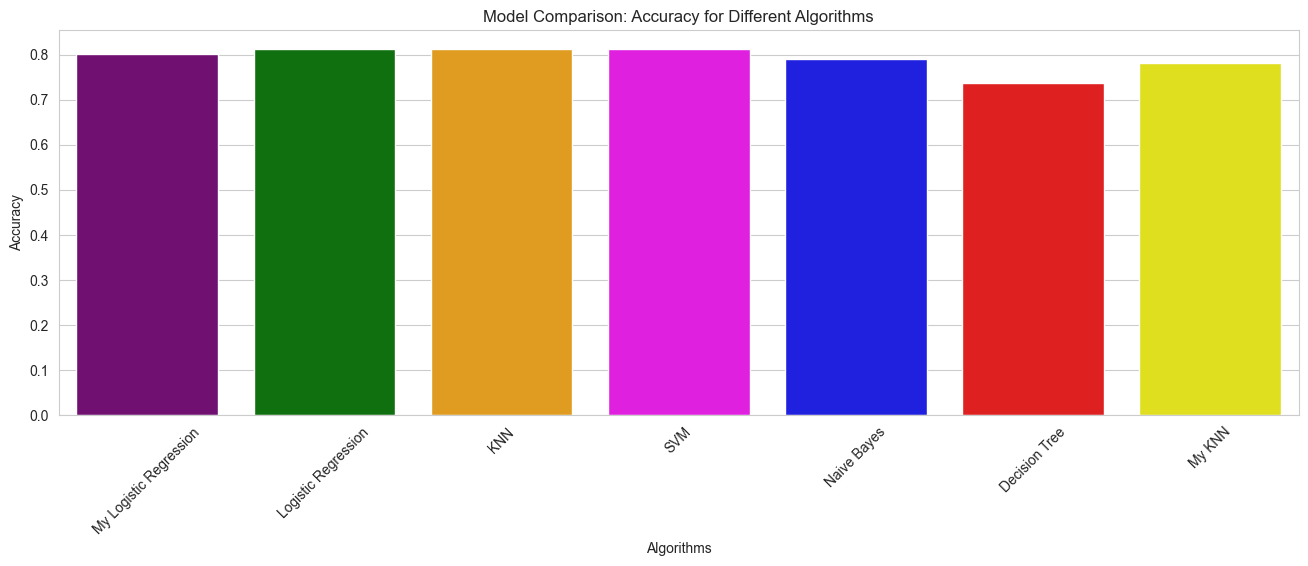

In [28]:
colors = ["purple", "green", "orange", "magenta", "blue", "red", "yellow"]

sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.xticks(rotation=45)
plt.title("Model Comparison: Accuracy for Different Algorithms")
plt.show()

## Confusion Matrix

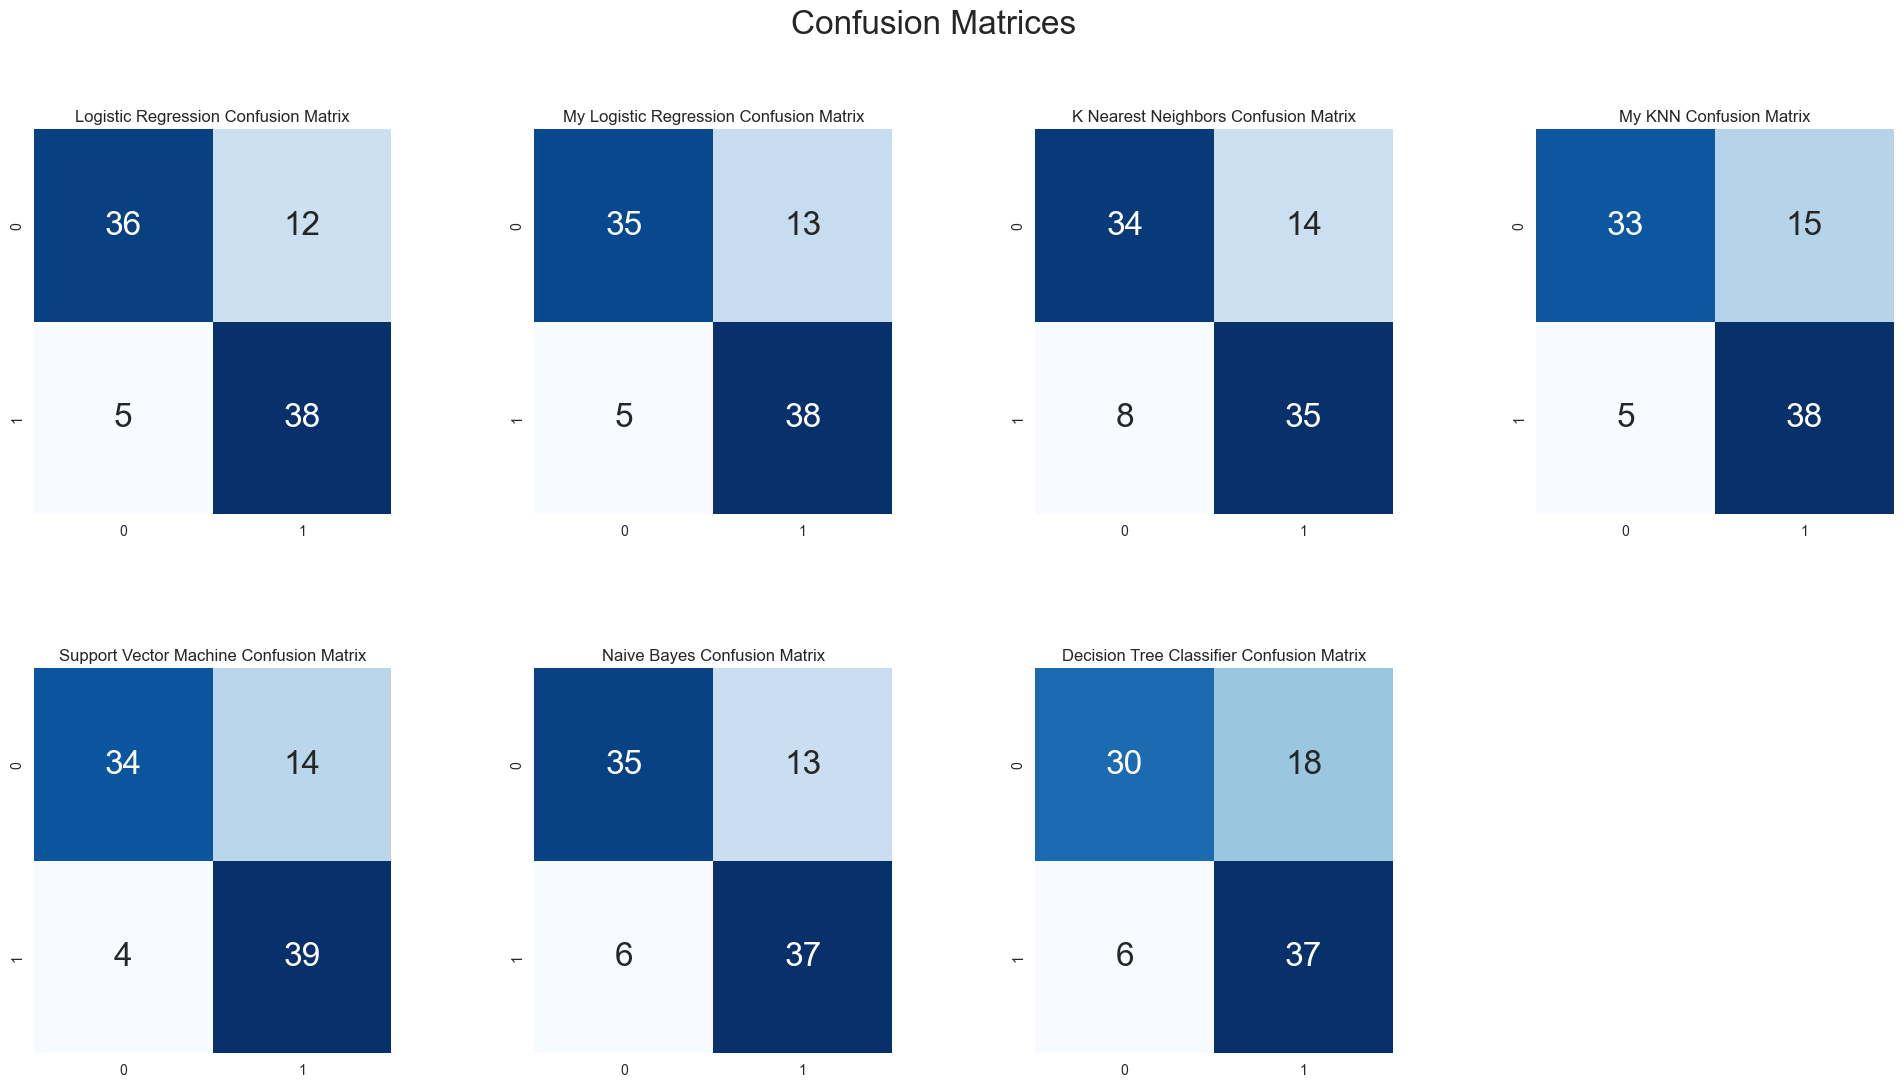

In [32]:
from sklearn.metrics import confusion_matrix
lr = LogisticRegression(max_iter=10000)  
lr.fit(X_train_scaled, y_train)  # Логистическая регрессия

knn3 = KNeighborsClassifier(n_neighbors=1)
knn3.fit(X_train_scaled, y_train)  # KNN

svm = SVC()
svm.fit(X_train_scaled, y_train)  # SVM

nb = GaussianNB()
nb.fit(X_train_scaled, y_train)  # Naive Bayes

dtc = DecisionTreeClassifier()
dtc.fit(X_train_scaled, y_train)  # Decision Tree

my_lr_model.fit(X_train_scaled, y_train)
myknn_model.fit(X_train_scaled, y_train)

y_head_lr = lr.predict(X_test_scaled)  
y_head_my_lr_model = my_lr_model.predict(X_test_scaled)  
y_head_knn = knn3.predict(X_test_scaled)  
y_head_myknn = myknn_model.predict(X_test_scaled)
y_head_svm = svm.predict(X_test_scaled)  
y_head_nb = nb.predict(X_test_scaled)    
y_head_dtc = dtc.predict(X_test_scaled)  

cm_lr = confusion_matrix(y_test, y_head_lr)
cm_mylogreg = confusion_matrix(y_test, y_head_my_lr_model)
cm_knn = confusion_matrix(y_test, y_head_knn)
cm_myknn = confusion_matrix(y_test, y_head_myknn)
cm_svm = confusion_matrix(y_test, y_head_svm)
cm_nb = confusion_matrix(y_test, y_head_nb)
cm_dtc = confusion_matrix(y_test, y_head_dtc)

plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.subplot(2, 4, 1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2, 4, 2)
plt.title("My Logistic Regression Confusion Matrix")
sns.heatmap(cm_mylogreg, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2, 4, 3)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2, 4, 4)
plt.title("My KNN Confusion Matrix")
sns.heatmap(cm_myknn, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2, 4, 5)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2, 4, 6)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2, 4, 7)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dtc, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.show()

В целом у нас получилось реализовать модели по точности схожие с готовыми, Recall высокое модели хорошо распознают положительные случаи. Precision ниже, модели часто ошибаются. Так же лучшими для решения данной задачи оказались: Логистическая регрессия и метод k ближайших соседей.

## Повторим то же самое для другого датасета

## Чтение данных

In [6]:
df = pd.read_csv('dataset/breast-cancer.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Возьмём данные по классификации рака молочной железа на доброкачественный и злокачественный, которые можно скачать [тут](https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset).

Описание датасета: <br>

* ID - Уникальный идентификатор для каждого пациента (удаляется в процессе анализа).
* diagnosis - Диагноз опухоли (M - злокачественная, B - доброкачественная).
* radius_mean - Средний радиус (среднее расстояние от центра до границы).
* texture_mean - Средняя текстура (стандартное отклонение значений серого уровня).
* perimeter_mean - Средний периметр.
* area_mean - Средняя площадь.
* smoothness_mean - Средняя гладкость (локальные вариации в длине радиуса).
* compactness_mean - Средняя компактность (периметр^2 / площадь - 1.0).
* concavity_mean - Средняя вогнутость (степень вогнутости частей контура).
* concave points_mean - Среднее количество вогнутых точек на контуре.
* symmetry_mean - Средняя симметрия.
* fractal_dimension_mean - Средняя фрактальная размерность (приближение "корабельности" границы).
* radius_se - Стандартная ошибка радиуса.
* texture_se - Стандартная ошибка текстуры.
* perimeter_se - Стандартная ошибка периметра.
* area_se - Стандартная ошибка площади.
* smoothness_se - Стандартная ошибка гладкости.
* compactness_se - Стандартная ошибка компактности.
* concavity_se - Стандартная ошибка вогнутости.
* concave points_se - Стандартная ошибка количества вогнутых точек.
* symmetry_se - Стандартная ошибка симметрии.
* fractal_dimension_se - Стандартная ошибка фрактальной размерности.
* radius_worst - Наихудший радиус.
* texture_worst - Наихудшая текстура.
* perimeter_worst - Наихудший периметр.
* area_worst - Наихудшая площадь.
* smoothness_worst - Наихудшая гладкость.
* compactness_worst - Наихудшая компактность.
* concavity_worst - Наихудшая вогнутость.
* concave points_worst - Наихудшее количество вогнутых точек.
* symmetry_worst - Наихудшая симметрия.
* fractal_dimension_worst - Наихудшая фрактальная размерность.

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Diagnosis** тип опухоли.

In [7]:
print(df.isnull().sum())

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


In [8]:
print(df.duplicated().sum())

0


Пустых строк нет,дубликатов нет

In [9]:
df.drop(['id'], axis=1, inplace=True)

Удалим id, ненужный признак

## Разведочный анализ данных

**Посмотрим распределение признаков**

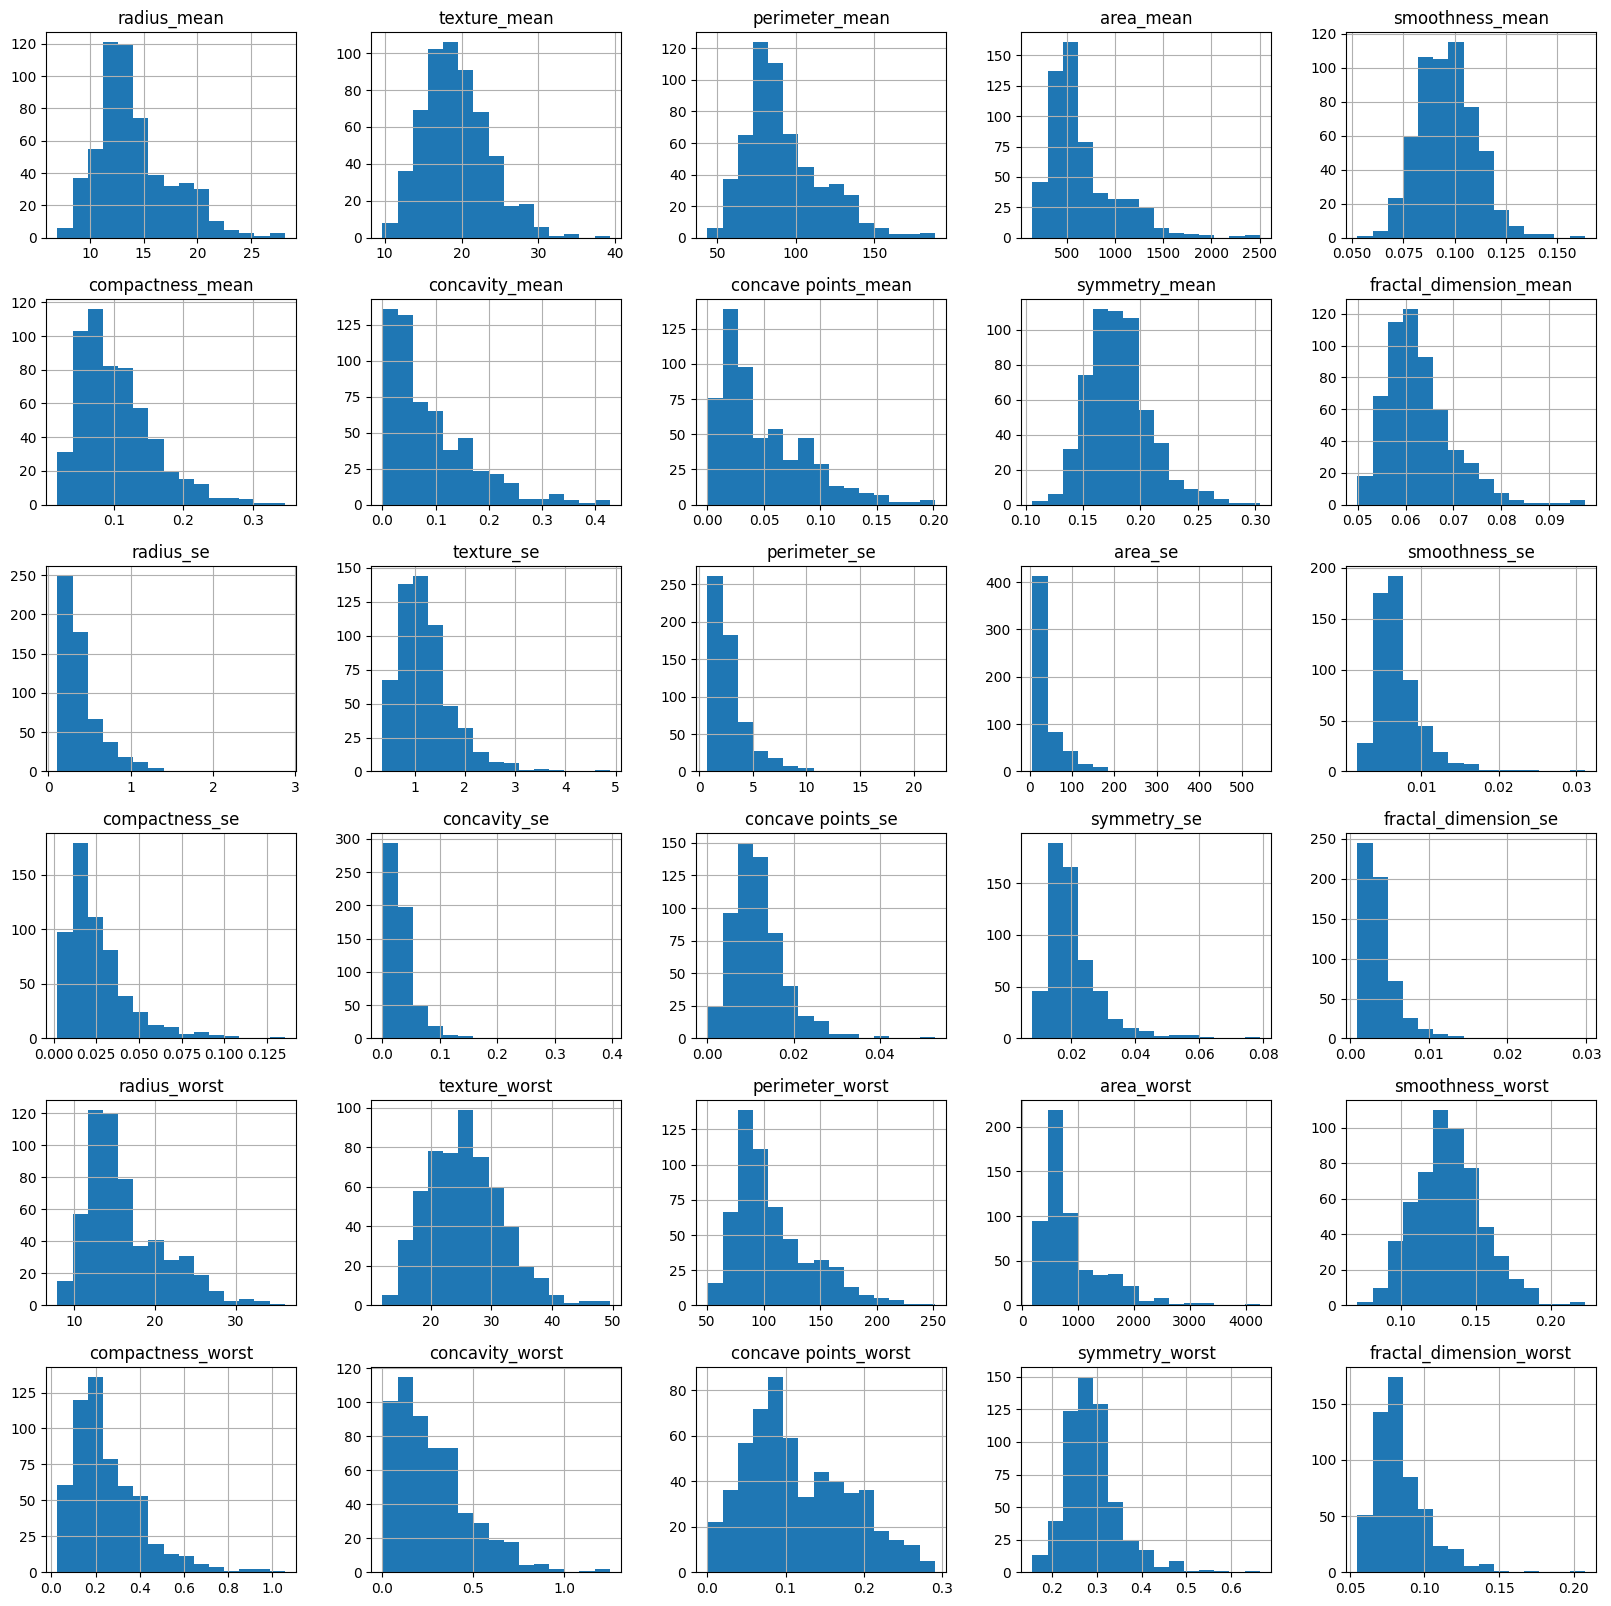

In [10]:
df.hist(bins=15, figsize=(20, 20))
plt.show()

**Посмотрим корреляцию признаков**

In [11]:
df['diagnosis'] = df['diagnosis'].apply(lambda x: 1 if x == 'M' else 0)

Закодируем искомый признак - 1 Злокачественная, 0 доброкачественная

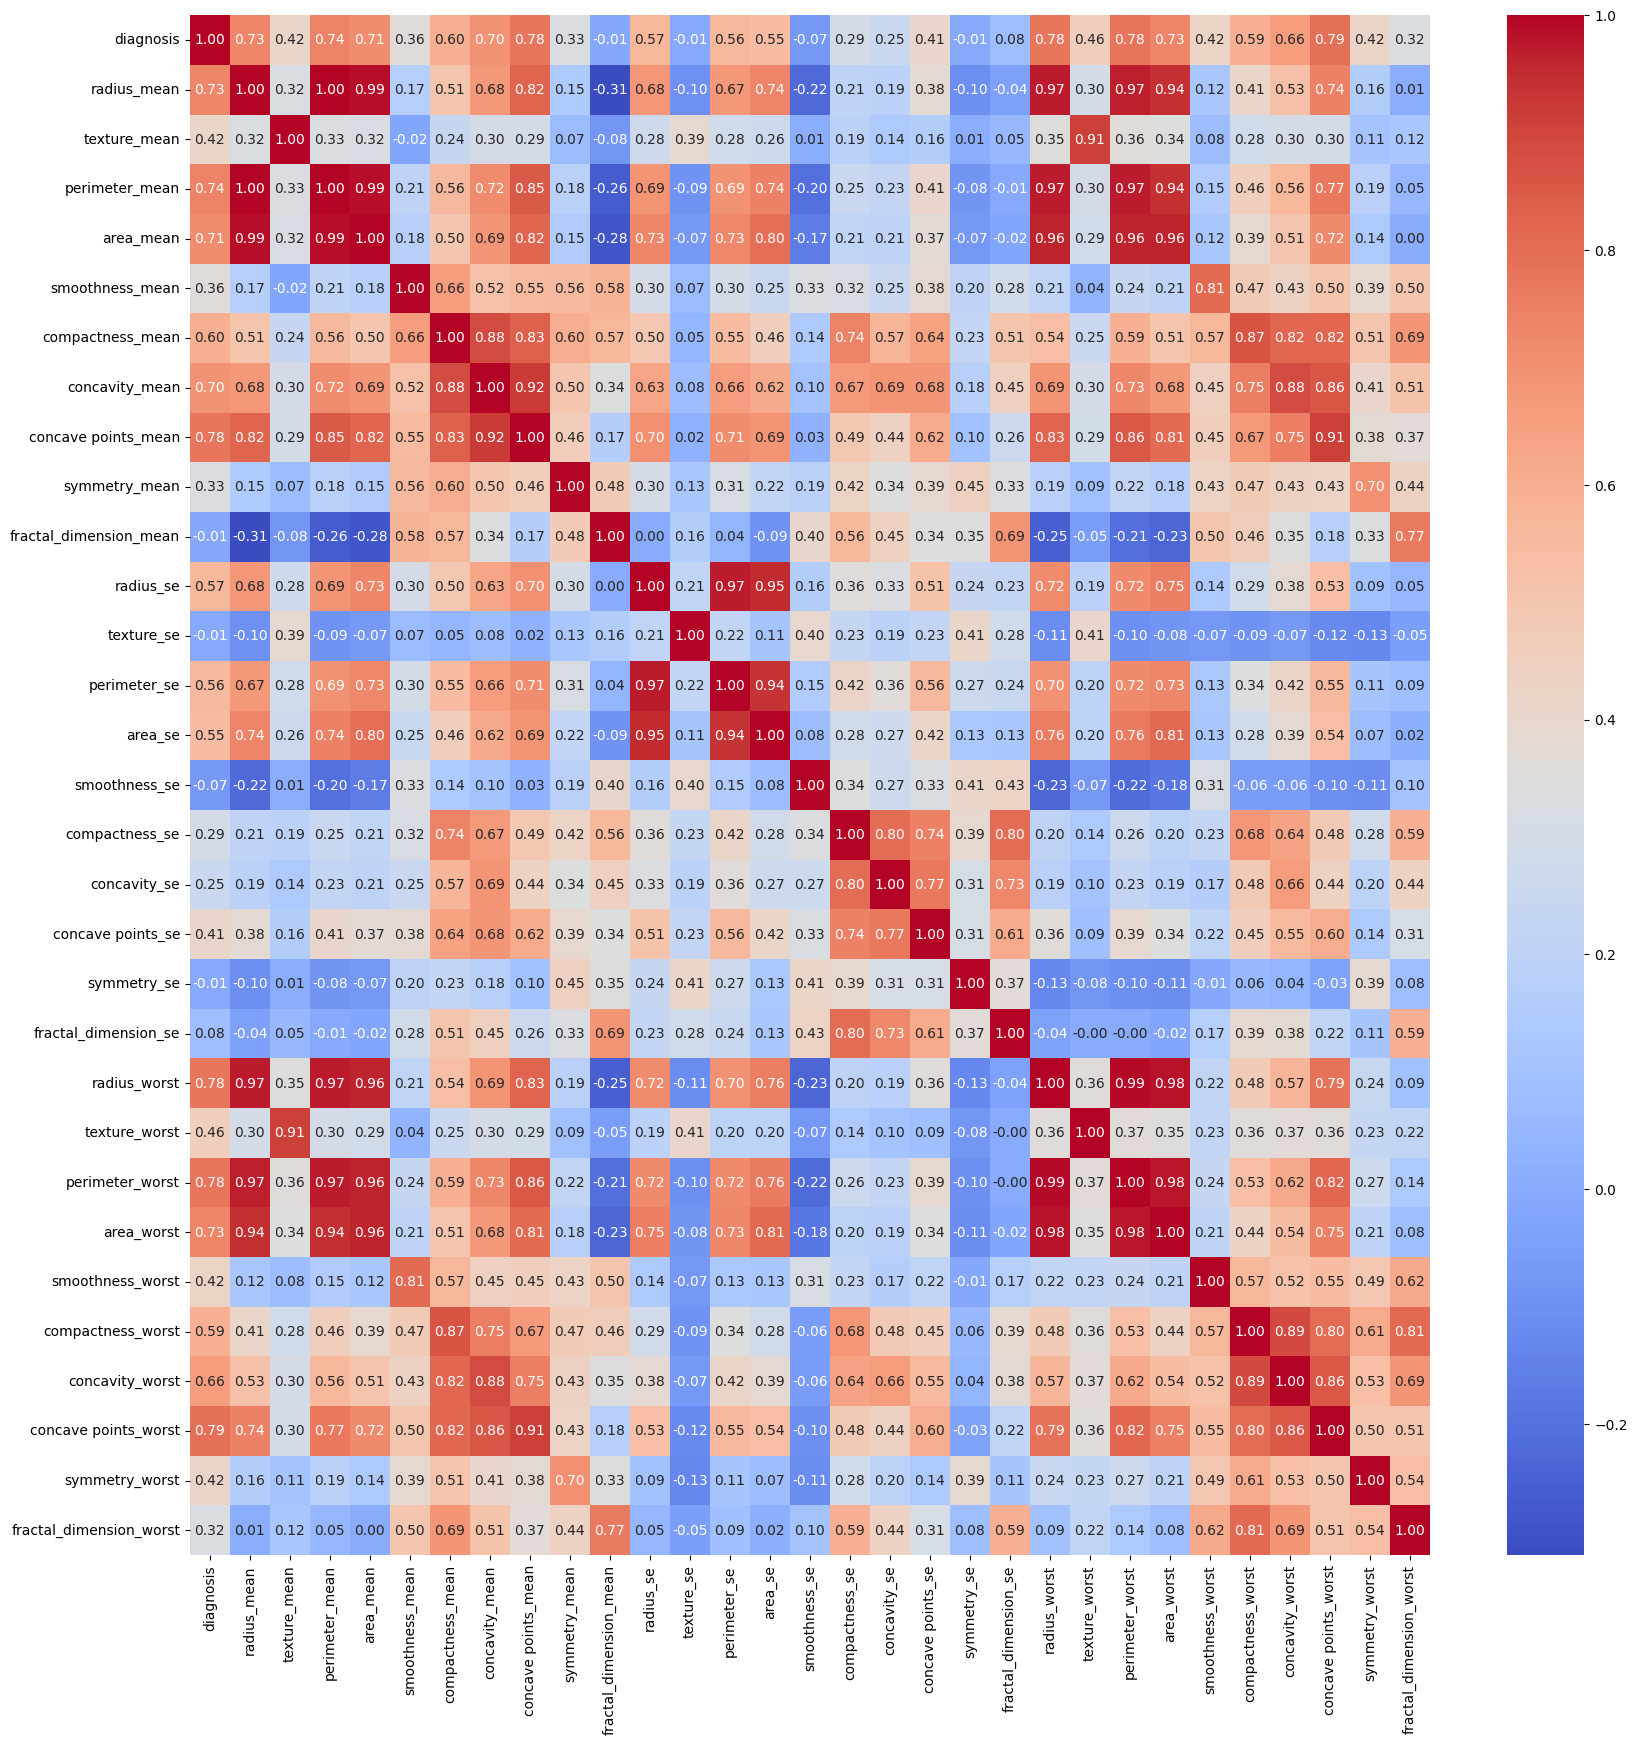

In [13]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

Признаки fractal_dimension_mean, texture_se, smoothness_se, symmetry_se, fractal_dimension_se, имеют малую корреляцию с предсказываемым признаком diagnosis

In [14]:
df = df.drop(columns=['fractal_dimension_mean', 'texture_se', 'smoothness_se', 'symmetry_se', 'fractal_dimension_se'])

Высококоррелирующие признаки содержат полезную информацию, их удалять не будем

## Масштабирование

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

y = df['diagnosis']
X = df.drop(columns=['diagnosis'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)


X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

## Кросс-валидация и гиперпараметры

In [19]:
from sklearn.model_selection import cross_val_score

my_lr_model = MyLogisticRegression(learning_rate=0.01, iterations=1000)  

cv_scores = cross_val_score(my_lr_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV accuracy = %.4f" % np.mean(cv_scores))

Cross validation scores:
	 0.9750
	0.9750
	0.9750
	0.9494
	0.9747
Mean CV accuracy = 0.9698


**Качество модели хорошо бы сравнить. Например, с глупым предсказателем.**

In [20]:
from sklearn.metrics import accuracy_score

stupid_pred_train = np.full_like(y_train, y_train.mean() > 0.5)
stupid_pred_test = np.full_like(y_test, y_train.mean() > 0.5)

print("Train accuracy with stupid predictor:", accuracy_score(y_train, stupid_pred_train))
print("Test accuracy with stupid predictor:", accuracy_score(y_test, stupid_pred_test))

Train accuracy with stupid predictor: 0.6256281407035176
Test accuracy with stupid predictor: 0.631578947368421


Видим, что наша модель сильно точнее чем предсказание наиболее частого класса

In [21]:
my_lr_model.fit(X_train_scaled, y_train)
y_test_pred = my_lr_model.predict(X_test_scaled)

my_lr_test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy with our model:", my_lr_test_accuracy)
accuracies = {}
accuracies['My Logistic Regression'] = my_lr_test_accuracy

Test accuracy with our model: 0.9824561403508771


## Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=10000)

cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV accuracy = %.4f" % np.mean(cv_scores))

lr_model.fit(X_train_scaled, y_train)

y_test_pred = lr_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy with Logistic Regression:", test_accuracy)
accuracies['Logistic Regression'] = test_accuracy

Cross validation scores:
	 0.9750
	0.9500
	1.0000
	0.9747
	0.9620
Mean CV accuracy = 0.9723
Test accuracy with Logistic Regression: 0.9883040935672515


## K-Nearest Neighbour (KNN) Classification

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)  # Можно настроить n_neighbors

cv_scores = cross_val_score(knn_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross validation scores (KNN):\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV accuracy (KNN) = %.4f" % np.mean(cv_scores))

knn_model.fit(X_train_scaled, y_train)

y_test_pred = knn_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy with KNN:", test_accuracy)
accuracies['KNN'] = test_accuracy

Cross validation scores (KNN):
	 0.9500
	0.9500
	0.9750
	0.9620
	0.9494
Mean CV accuracy (KNN) = 0.9573
Test accuracy with KNN: 0.9707602339181286


## Support Vector Machine (SVM)

In [30]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', C=1.0)  # Параметры можно настроить

cv_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross validation scores (SVM):\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV accuracy (SVM) = %.4f" % np.mean(cv_scores))

svm_model.fit(X_train_scaled, y_train)

y_test_pred = svm_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy with SVM:", test_accuracy)
accuracies['SVM'] = test_accuracy

Cross validation scores (SVM):
	 0.9750
	0.9500
	1.0000
	0.9747
	0.9494
Mean CV accuracy (SVM) = 0.9698
Test accuracy with SVM: 0.9766081871345029


## Naive Bayes Algorithm

In [25]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()

cv_scores = cross_val_score(nb_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross validation scores (Naive Bayes):\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV accuracy (Naive Bayes) = %.4f" % np.mean(cv_scores))

nb_model.fit(X_train_scaled, y_train)

y_test_pred = nb_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy with Naive Bayes:", test_accuracy)
accuracies['Naive Bayes'] = test_accuracy

Cross validation scores (Naive Bayes):
	 0.9500
	0.9500
	0.8875
	0.9367
	0.9367
Mean CV accuracy (Naive Bayes) = 0.9322
Test accuracy with Naive Bayes: 0.935672514619883


## Decision Tree Algorithm

In [26]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)

cv_scores = cross_val_score(dt_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross validation scores (Decision Tree):\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV accuracy (Decision Tree) = %.4f" % np.mean(cv_scores))

dt_model.fit(X_train_scaled, y_train)

y_test_pred = dt_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy with Decision Tree:", test_accuracy)
accuracies['Decision Tree'] = test_accuracy

Cross validation scores (Decision Tree):
	 0.9250
	0.9125
	0.9000
	0.9367
	0.9114
Mean CV accuracy (Decision Tree) = 0.9171
Test accuracy with Decision Tree: 0.9532163742690059


## Реализация метода ближайших соседей

In [28]:
myknn_model = MyKNN(k=5)

cv_scores = cross_val_score(myknn_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV accuracy = %.4f" % np.mean(cv_scores))

myknn_model.fit(X_train_scaled, y_train)

y_test_pred = myknn_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy with KNN:", test_accuracy)
accuracies['My KNN'] = test_accuracy

Cross validation scores:
	 0.9375
	0.9500
	0.9625
	0.9620
	0.9367
Mean CV accuracy = 0.9497
Test accuracy with KNN: 0.9707602339181286


## Comparing Models

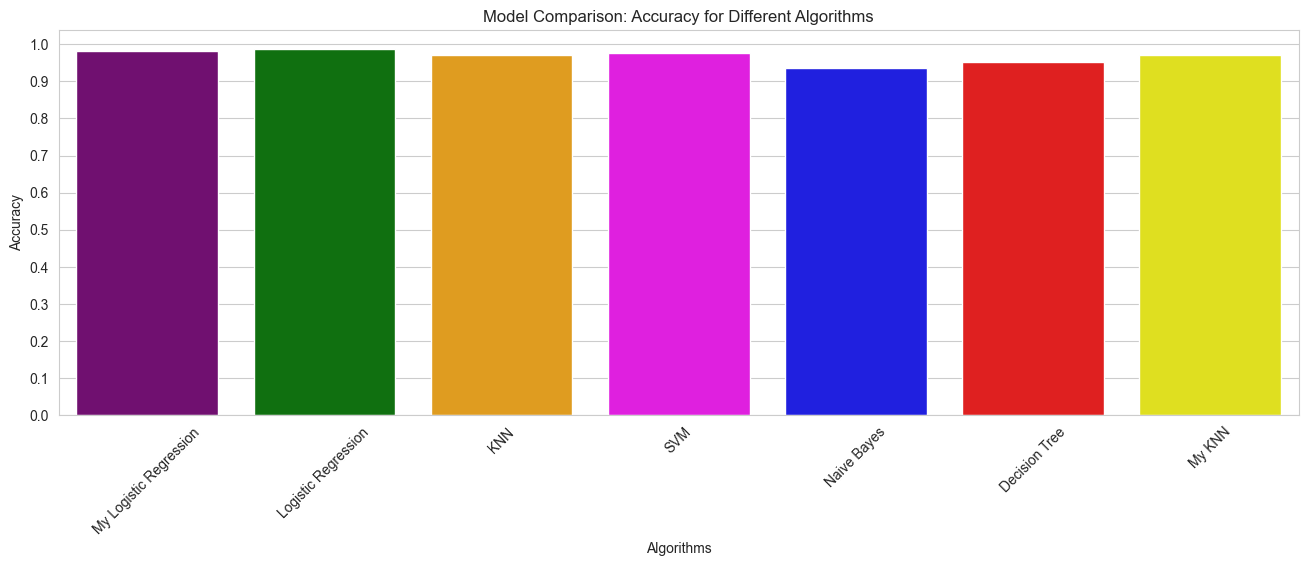

In [31]:
colors = ["purple", "green", "orange", "magenta", "blue", "red", "yellow"]

sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.xticks(rotation=45)
plt.title("Model Comparison: Accuracy for Different Algorithms")
plt.show()

## Confusion Matrix

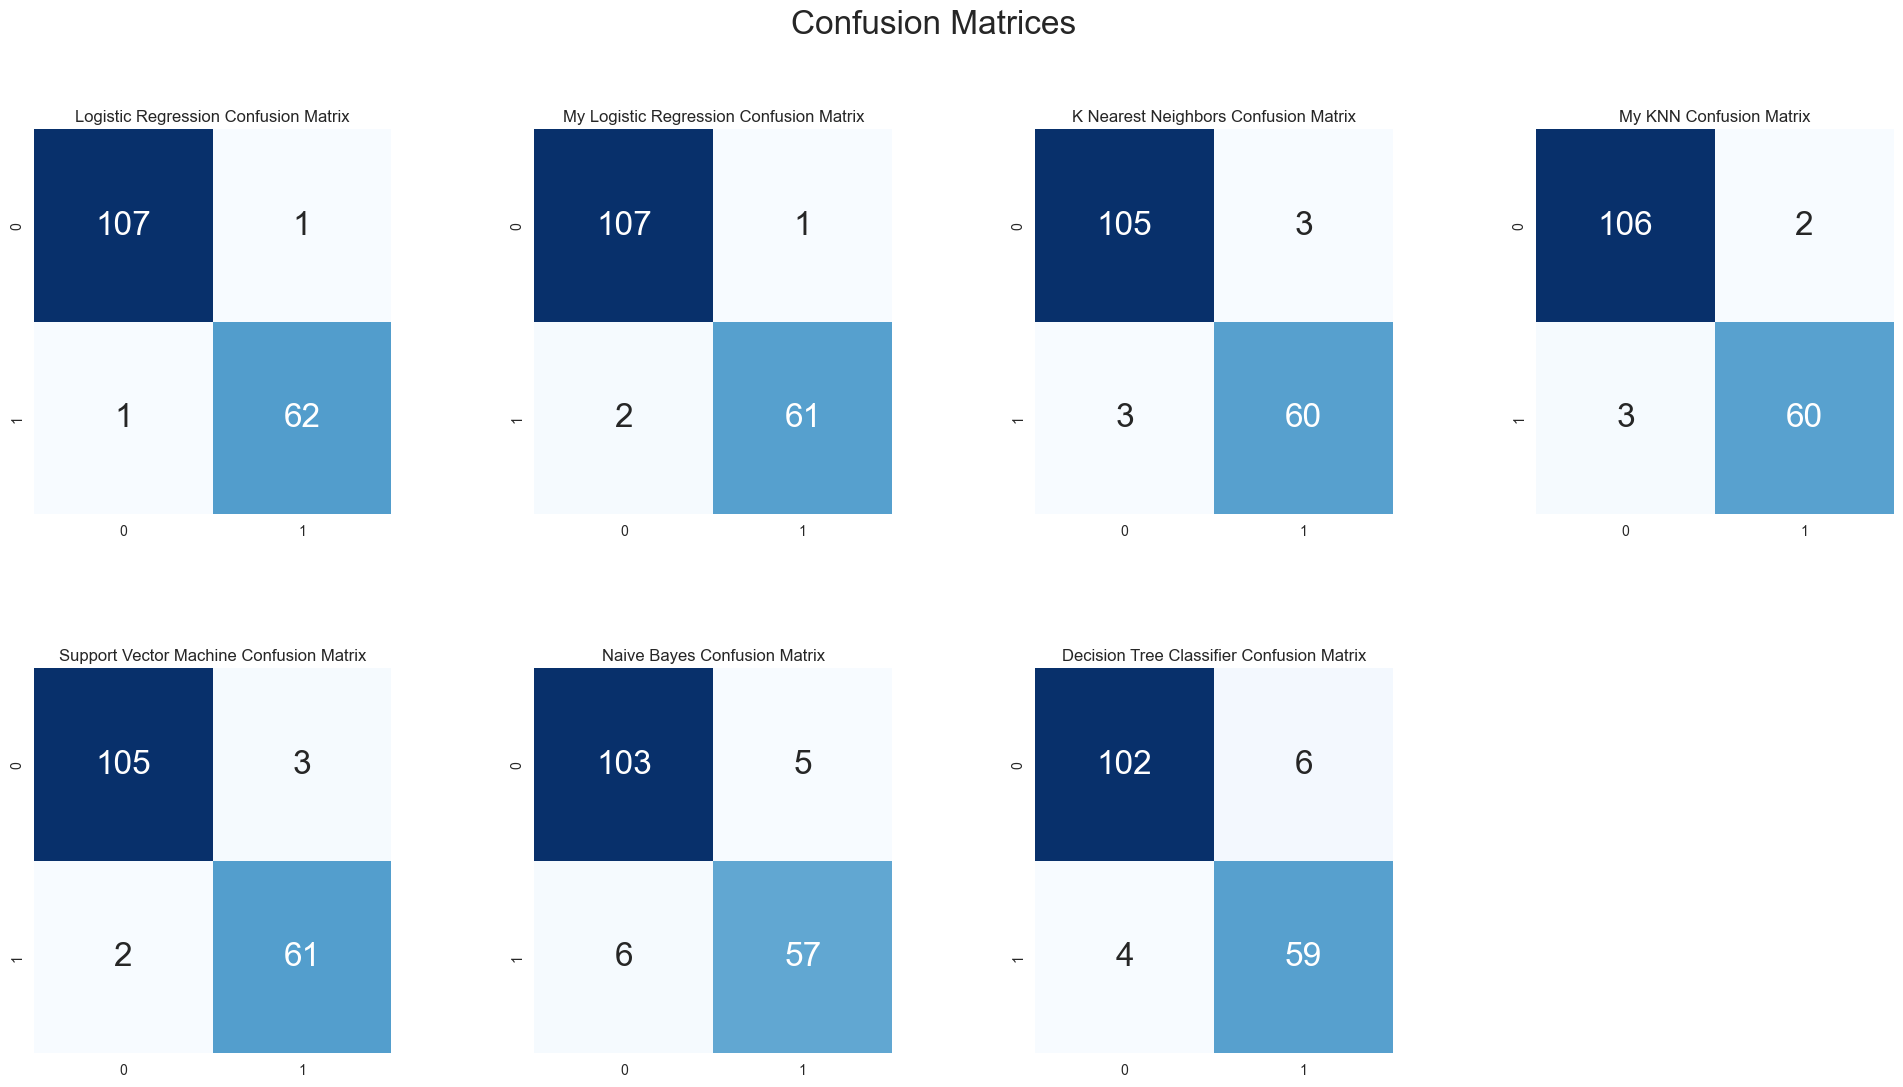

In [32]:
from sklearn.metrics import confusion_matrix
lr = LogisticRegression(max_iter=10000)  
lr.fit(X_train_scaled, y_train)  # Логистическая регрессия

knn3 = KNeighborsClassifier(n_neighbors=1)
knn3.fit(X_train_scaled, y_train)  # KNN

svm = SVC()
svm.fit(X_train_scaled, y_train)  # SVM

nb = GaussianNB()
nb.fit(X_train_scaled, y_train)  # Naive Bayes

dtc = DecisionTreeClassifier()
dtc.fit(X_train_scaled, y_train)  # Decision Tree

my_lr_model.fit(X_train_scaled, y_train)
myknn_model.fit(X_train_scaled, y_train)

y_head_lr = lr.predict(X_test_scaled)  
y_head_my_lr_model = my_lr_model.predict(X_test_scaled)  
y_head_knn = knn3.predict(X_test_scaled)  
y_head_myknn = myknn_model.predict(X_test_scaled)
y_head_svm = svm.predict(X_test_scaled)  
y_head_nb = nb.predict(X_test_scaled)    
y_head_dtc = dtc.predict(X_test_scaled)  

cm_lr = confusion_matrix(y_test, y_head_lr)
cm_mylogreg = confusion_matrix(y_test, y_head_my_lr_model)
cm_knn = confusion_matrix(y_test, y_head_knn)
cm_myknn = confusion_matrix(y_test, y_head_myknn)
cm_svm = confusion_matrix(y_test, y_head_svm)
cm_nb = confusion_matrix(y_test, y_head_nb)
cm_dtc = confusion_matrix(y_test, y_head_dtc)

plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.subplot(2, 4, 1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2, 4, 2)
plt.title("My Logistic Regression Confusion Matrix")
sns.heatmap(cm_mylogreg, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2, 4, 3)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2, 4, 4)
plt.title("My KNN Confusion Matrix")
sns.heatmap(cm_myknn, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2, 4, 5)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2, 4, 6)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.subplot(2, 4, 7)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dtc, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24})

plt.show()

В результате модель показывает очень хорошие результаты по всем метрикам. В данном случае собственные реализации оказались хуже встроенных, но не сильно.